In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '85-efficientnetb6'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import tensorflow_addons as tfa
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
REPLICAS = strategy.num_replicas_in_sync
print("REPLICAS: ", REPLICAS)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 384,
  "WIDTH": 384,
  "CHANNELS": 3,
  "BATCH_SIZE": 32,
  "EPOCHS": 12,
  "LEARNING_RATE": 1e-3,
  "ES_PATIENCE": 5,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 11,
  "BASE_MODEL": 'EfficientNetB6',
  "BASE_MODEL_WEIGHTS": 'imagenet',
  "DATASET_PATH": 'melanoma-384x384'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB6',
 'BASE_MODEL_WEIGHTS': 'imagenet',
 'BATCH_SIZE': 32,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-384x384',
 'EPOCHS': 12,
 'ES_PATIENCE': 5,
 'HEIGHT': 384,
 'LEARNING_RATE': 0.001,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 11,
 'WIDTH': 384}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
train = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-e73569ee9d44308363027e79908294593e80b1e12e18e57ef065397c'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image):

    image = transform(image, DIM=config['WIDTH'])
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
    return image

ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

## Auxiliary functions

In [12]:
#@title
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']

def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0
 
def prepare_image(img, augment=True, dim=256):    
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = data_augment(img)
                      
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def get_dataset(files, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True, batch_size=16, dim=256):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, dim=dim), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

## Learning rate scheduler

In [13]:
#@title
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

# Model

In [14]:
#@title
# Initial bias
pos = len(train[train['target'] == 1])
neg = len(train[train['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(train)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [15]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB6(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [16]:
skf = KFold(n_splits=config['N_FOLDS'], shuffle=True, random_state=SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = []; history_list = []
preds = np.zeros((count_data_items(TEST_FILENAMES), 1))

for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
    print('\nFOLD: %d' % (fold+1))
    if tpu: tf.tpu.experimental.initialize_tpu_system(tpu)
    
    # CREATE TRAIN AND VALIDATION SUBSETS
    TRAINING_FILENAMES = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxT])
    np.random.shuffle(TRAINING_FILENAMES)
    files_valid = tf.io.gfile.glob([GCS_PATH + '/train%.2i*.tfrec'%x for x in idxV])
    TEST_FILENAMES = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))
    
    # BUILD MODEL
    K.clear_session()
    model_path = f'model_fold_{fold}.h5'
    with strategy.scope():
        model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
        opt = optimizers.Adam(learning_rate=0.001)
        loss = losses.BinaryCrossentropy(label_smoothing=0.05) 
        model.compile(optimizer=opt, loss=loss, metrics=['AUC'])
        
    checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)
   
    # TRAIN
    print('Training...')
    history = model.fit(get_dataset(TRAINING_FILENAMES, augment=True, shuffle=True, repeat=True,
                                    dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']), 
                        validation_data=get_dataset(files_valid, augment=False, shuffle=False,
                                                    repeat=False, dim=config['HEIGHT']), 
                        steps_per_epoch=count_data_items(TRAINING_FILENAMES)/config['BATCH_SIZE']//REPLICAS,
                        epochs=config['EPOCHS'], 
                        callbacks=[checkpoint, get_lr_callback(config['BATCH_SIZE'])], 
                        verbose=2).history
    
    history_list.append(history)

    # save last epoch weights
    model.save_weights(MODEL_BASE_PATH + 'last_' + model_path)
    
    print('Loading best model...')
    model.load_weights(MODEL_BASE_PATH + model_path)
    
    # PREDICT OOF USING TTA
    print('Predicting OOF with TTA...')
    ds_valid = get_dataset(files_valid, labeled=False, return_image_names=False, augment=True,repeat=True, 
                           shuffle=False, dim=config['HEIGHT'], batch_size=config['BATCH_SIZE']*4)
    ct_valid = count_data_items(files_valid)
    STEPS = config['TTA_STEPS'] * ct_valid/config['BATCH_SIZE']/4/REPLICAS
    pred = model.predict(ds_valid,steps=STEPS, verbose=2)[:config['TTA_STEPS']*ct_valid,] 
    oof_pred.append(np.mean(pred.reshape((ct_valid,config['TTA_STEPS']),order='F'),axis=1) )                 
    
    # GET OOF TARGETS AND NAMES
    ds_valid = get_dataset(files_valid, augment=False, repeat=False, dim=config['HEIGHT'],
            labeled=True, return_image_names=True)
    oof_tar.append(np.array([target.numpy() for img, target in iter(ds_valid.unbatch())]) )
    oof_folds.append( np.ones_like(oof_tar[-1],dtype='int8')*fold )
    ds = get_dataset(files_valid, augment=False, repeat=False, dim=config['HEIGHT'],
                labeled=False, return_image_names=True)
    oof_names.append(np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())]))
    
    # PREDICT TEST USING TTA
    print('Predicting Test with TTA...')
    ds_test = get_dataset(TEST_FILENAMES,labeled=False,return_image_names=False,augment=True,
            repeat=True,shuffle=False,dim=config['HEIGHT'],batch_size=config['BATCH_SIZE']*4)
    ct_test = count_data_items(TEST_FILENAMES)
    STEPS = config['TTA_STEPS'] * ct_test/config['BATCH_SIZE']/4/REPLICAS
    pred = model.predict(ds_test,steps=STEPS,verbose=2)[:config['TTA_STEPS']*ct_test,] 
    preds[:,0] += np.mean(pred.reshape((ct_test,config['TTA_STEPS']), order='F'),axis=1) * (1/config['N_USED_FOLDS'])
    
    # REPORT RESULTS
    auc = roc_auc_score(oof_tar[-1], oof_pred[-1])
    oof_val.append(np.max( history['val_auc'] ))
    print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1, oof_val[-1],auc))


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


165527552/165527152 [==============================] - 2s 0us/step
Training...
Epoch 1/12
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


102/102 - 161s - auc: 0.5441 - loss: 0.1834 - val_auc: 0.5359 - val_loss: 0.1827 - lr: 5.0000e-06
Epoch 2/12
102/102 - 129s - auc: 0.7236 - loss: 0.1737 - val_auc: 0.7615 - val_loss: 0.1724 - lr: 6.8000e-05
Epoch 3/12
102/102 - 129s - auc: 0.8376 - loss: 0.1679 - val_auc: 0.8692 - val_loss: 0.1658 - lr: 1.3100e-04
Epoch 4/12
102/102 - 129s - auc: 0.8563 - loss: 0.1630 - val_auc: 0.8727 - val_loss: 0.1647 - lr: 1.9400e-04
Epoch 5/12
102/102 - 129s - auc: 0.8787 - loss: 0.1652 - val_auc: 0.8957 - val_loss: 0.1618 - lr: 2.5700e-04
Epoch 6/12
102/102 - 123s - auc: 0.8888 - loss: 0.1615 - val_auc: 0.8530 - val_loss: 0.1649 - lr: 3.2000e-04
Epoch 7/12
102/102 - 123s - auc: 0.9111 - loss: 0.1591 - val_auc: 0.8516 - val_loss: 0.1640 - lr: 2.5620e-04
Epoch 8/12
102/102 - 130s - auc: 0.9192 - loss: 0.1565 - val_auc: 0.8751 - val_loss: 0.1616 - lr: 2.0516e-04
Epoch 9/12
102/102 - 124s - auc: 0.9432 - loss: 0.1518 - val_auc: 0.8882 - val_loss: 0.1618 - lr: 1.6433e-04
Epoch 10/12
102/102 - 130s - a

INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 156s - auc: 0.5636 - loss: 0.1840 - val_auc: 0.4658 - val_loss: 0.1870 - lr: 5.0000e-06
Epoch 2/12
102/102 - 131s - auc: 0.7430 - loss: 0.1747 - val_auc: 0.7164 - val_loss: 0.1734 - lr: 6.8000e-05
Epoch 3/12
102/102 - 130s - auc: 0.8500 - loss: 0.1626 - val_auc: 0.8124 - val_loss: 0.1687 - lr: 1.3100e-04
Epoch 4/12
102/102 - 130s - auc: 0.8564 - loss: 0.1672 - val_auc: 0.8327 - val_loss: 0.1675 - lr: 1.9400e-04
Epoch 5/12
102/102 - 130s - auc: 0.8650 - loss: 0.1644 - val_auc: 0.8238 - val_loss: 0.1670 - lr: 2.5700e-04
Epoch 6/12
102/102 - 129s - auc: 0.8880 - loss: 0.1625 - val_auc: 0.8503 - val_loss: 0.1655 - lr: 3.2000e-04
Epoch 7/12
102/102 - 124s - auc: 0.9041 - loss: 0.1572 - val_auc: 0.8802 - val_loss: 0.1671 - lr: 2.5620e-04
Epoch 8/12
102/102 - 124s - auc: 0.9162 - loss: 0.1582 - val_auc: 0.8609 - val_loss: 0.1677 - lr: 2.0516e-04
Epoch 9/12
102/102 - 124s - auc: 0.9406 - loss: 0.1515 - val_auc: 0.8626 - val_loss: 0.1672 - lr: 1.6433e-04
Epoch 1

INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 156s - auc: 0.5172 - loss: 0.1843 - val_auc: 0.4998 - val_loss: 0.1880 - lr: 5.0000e-06
Epoch 2/12
102/102 - 129s - auc: 0.7105 - loss: 0.1739 - val_auc: 0.7701 - val_loss: 0.1746 - lr: 6.8000e-05
Epoch 3/12
102/102 - 132s - auc: 0.8064 - loss: 0.1687 - val_auc: 0.8920 - val_loss: 0.1649 - lr: 1.3100e-04
Epoch 4/12
102/102 - 130s - auc: 0.8527 - loss: 0.1658 - val_auc: 0.8942 - val_loss: 0.1642 - lr: 1.9400e-04
Epoch 5/12
102/102 - 124s - auc: 0.8537 - loss: 0.1657 - val_auc: 0.8772 - val_loss: 0.1667 - lr: 2.5700e-04
Epoch 6/12
102/102 - 130s - auc: 0.8659 - loss: 0.1635 - val_auc: 0.9143 - val_loss: 0.1620 - lr: 3.2000e-04
Epoch 7/12
102/102 - 124s - auc: 0.8924 - loss: 0.1609 - val_auc: 0.9103 - val_loss: 0.1624 - lr: 2.5620e-04
Epoch 8/12
102/102 - 124s - auc: 0.9249 - loss: 0.1566 - val_auc: 0.9033 - val_loss: 0.1631 - lr: 2.0516e-04
Epoch 9/12
102/102 - 124s - auc: 0.9301 - loss: 0.1551 - val_auc: 0.9118 - val_loss: 0.1634 - lr: 1.6433e-04
Epoch 1

INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 159s - auc: 0.5704 - loss: 0.1837 - val_auc: 0.5016 - val_loss: 0.1821 - lr: 5.0000e-06
Epoch 2/12
102/102 - 130s - auc: 0.7348 - loss: 0.1716 - val_auc: 0.7950 - val_loss: 0.1727 - lr: 6.8000e-05
Epoch 3/12
102/102 - 130s - auc: 0.8346 - loss: 0.1682 - val_auc: 0.8412 - val_loss: 0.1680 - lr: 1.3100e-04
Epoch 4/12
102/102 - 130s - auc: 0.8656 - loss: 0.1658 - val_auc: 0.8658 - val_loss: 0.1667 - lr: 1.9400e-04
Epoch 5/12
102/102 - 130s - auc: 0.8810 - loss: 0.1633 - val_auc: 0.8967 - val_loss: 0.1639 - lr: 2.5700e-04
Epoch 6/12
102/102 - 130s - auc: 0.9030 - loss: 0.1622 - val_auc: 0.8933 - val_loss: 0.1633 - lr: 3.2000e-04
Epoch 7/12
102/102 - 130s - auc: 0.9065 - loss: 0.1593 - val_auc: 0.9049 - val_loss: 0.1626 - lr: 2.5620e-04
Epoch 8/12
102/102 - 124s - auc: 0.9261 - loss: 0.1558 - val_auc: 0.8138 - val_loss: 0.1684 - lr: 2.0516e-04
Epoch 9/12
102/102 - 130s - auc: 0.9262 - loss: 0.1529 - val_auc: 0.8885 - val_loss: 0.1613 - lr: 1.6433e-04
Epoch 1

INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.56.73.250:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Training...
Epoch 1/12
102/102 - 157s - auc: 0.5557 - loss: 0.1856 - val_auc: 0.5210 - val_loss: 0.1845 - lr: 5.0000e-06
Epoch 2/12
102/102 - 130s - auc: 0.7368 - loss: 0.1707 - val_auc: 0.7280 - val_loss: 0.1748 - lr: 6.8000e-05
Epoch 3/12
102/102 - 130s - auc: 0.8241 - loss: 0.1679 - val_auc: 0.8522 - val_loss: 0.1664 - lr: 1.3100e-04
Epoch 4/12
102/102 - 130s - auc: 0.8612 - loss: 0.1653 - val_auc: 0.8664 - val_loss: 0.1662 - lr: 1.9400e-04
Epoch 5/12
102/102 - 130s - auc: 0.8658 - loss: 0.1653 - val_auc: 0.8717 - val_loss: 0.1626 - lr: 2.5700e-04
Epoch 6/12
102/102 - 124s - auc: 0.8874 - loss: 0.1635 - val_auc: 0.8368 - val_loss: 0.1675 - lr: 3.2000e-04
Epoch 7/12
102/102 - 123s - auc: 0.9040 - loss: 0.1607 - val_auc: 0.8697 - val_loss: 0.1637 - lr: 2.5620e-04
Epoch 8/12
102/102 - 124s - auc: 0.9246 - loss: 0.1559 - val_auc: 0.8808 - val_loss: 0.1707 - lr: 2.0516e-04
Epoch 9/12
102/102 - 124s - auc: 0.9487 - loss: 0.1508 - val_auc: 0.8413 - val_loss: 0.1646 - lr: 1.6433e-04
Epoch 1

## Model loss graph

Fold: 1


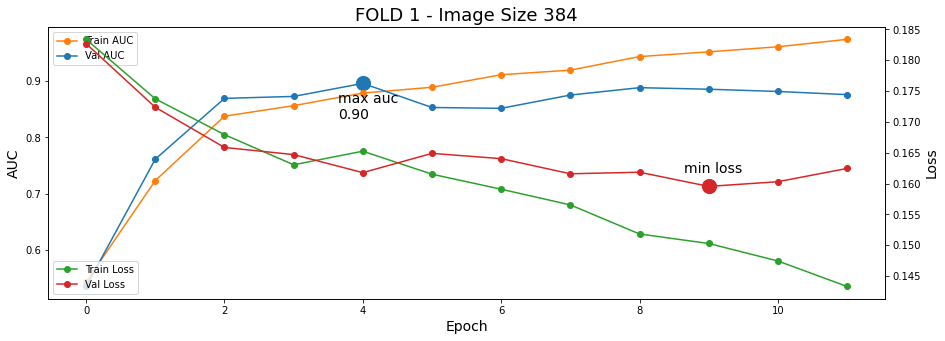

Fold: 2


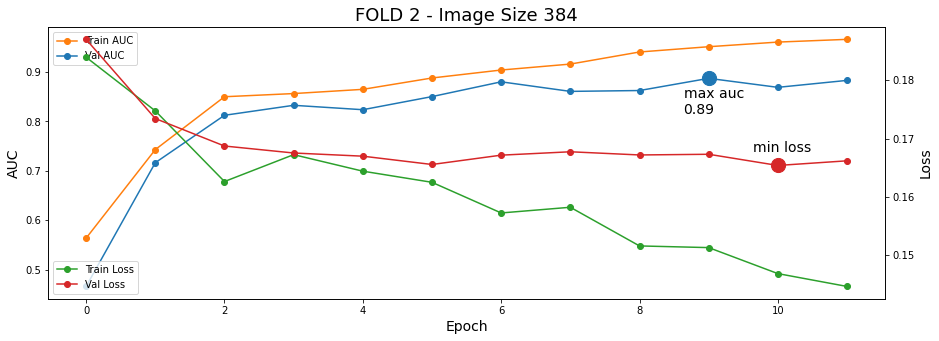

Fold: 3


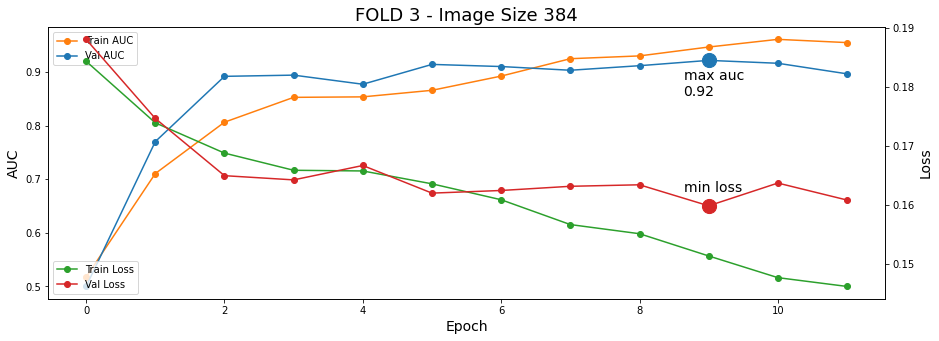

Fold: 4


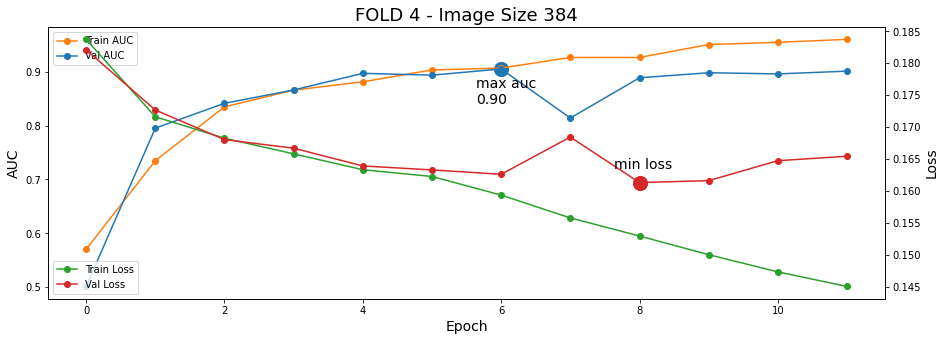

Fold: 5


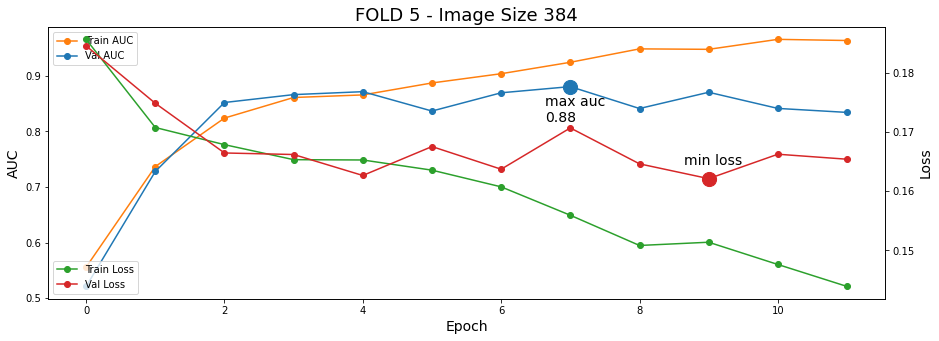

In [17]:
#@title
for n_fold, history in enumerate(history_list):
    print(f'Fold: {n_fold + 1}')
    ##### Plot metrics #####
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(config['EPOCHS']), history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(config['EPOCHS']), history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax(history['val_auc'])
    y = np.max(history['val_auc'])
    xdist = plt.xlim()[1] - plt.xlim()[0]
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4')
    plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC',size=14)
    plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(config['EPOCHS']), history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(config['EPOCHS']), history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin(history['val_loss'])
    y = np.min(history['val_loss'])
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728')
    plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('FOLD %i - Image Size %i' % (n_fold+1, config['HEIGHT']), size=18)
    plt.legend(loc=3)
    plt.show()

## Model loss graph aggregated

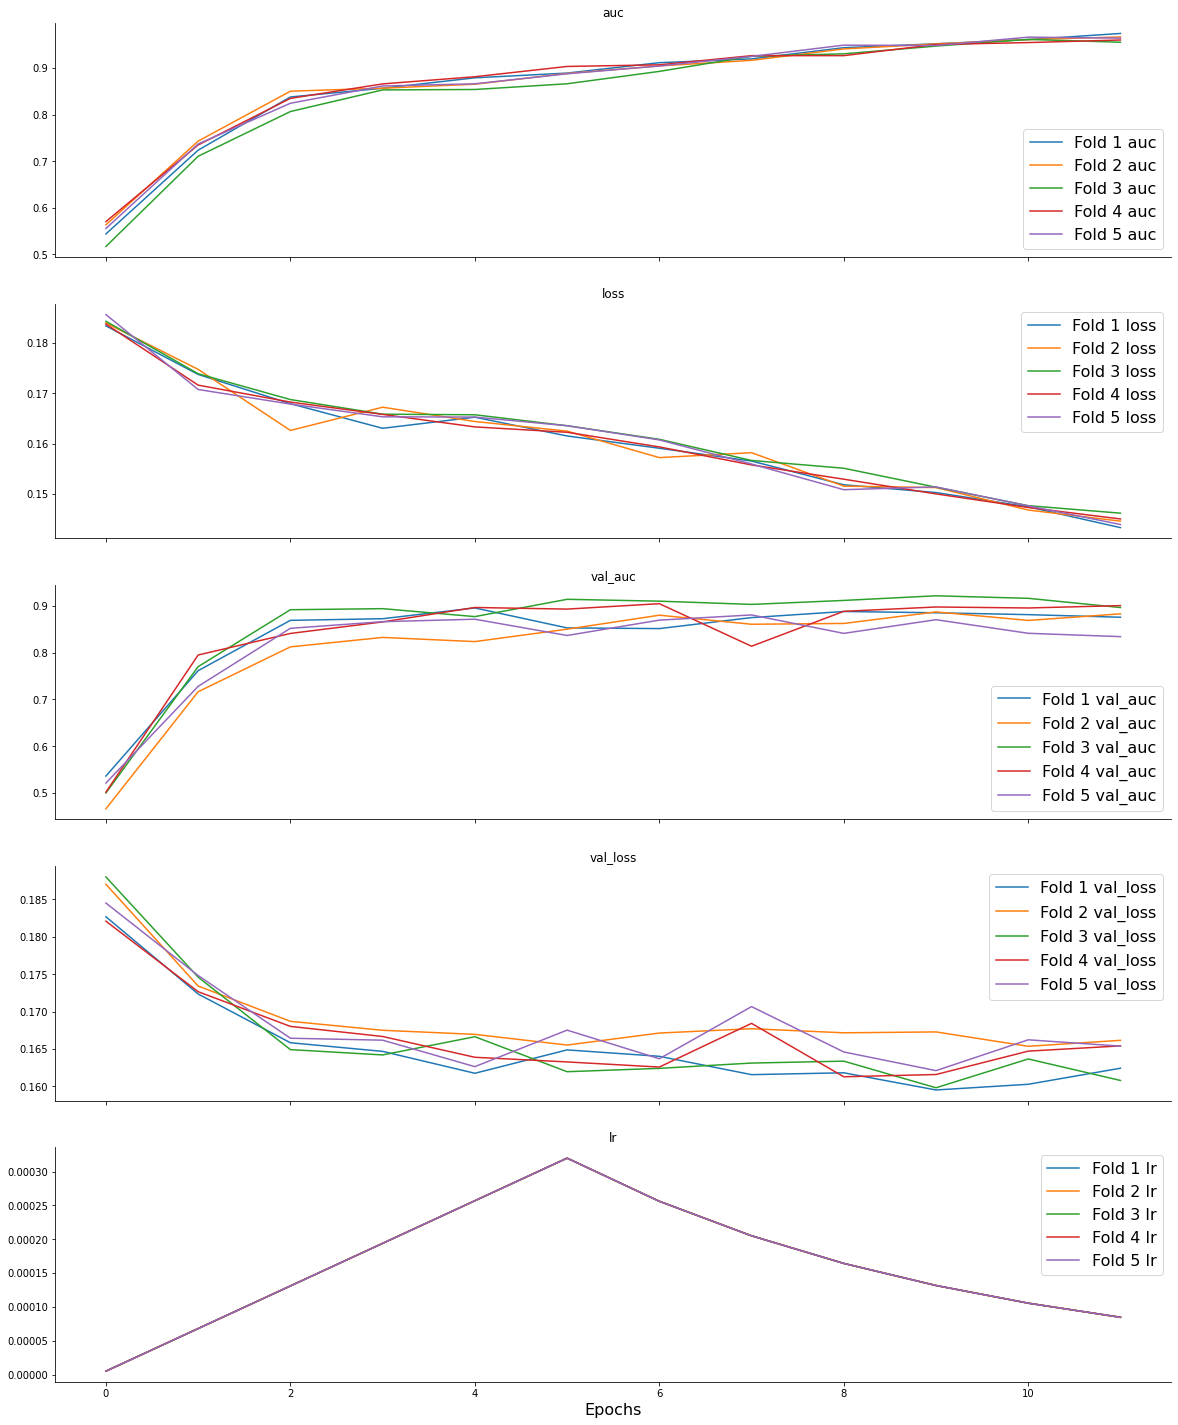

In [18]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [19]:
#@title
# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred)
true = np.concatenate(oof_tar)
names = np.concatenate(oof_names)
folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f' % auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(image_name=names, target=true, pred=oof, fold=folds))
df_oof.to_csv('oof.csv', index=False)
df_oof.head()

Overall OOF AUC with TTA = 0.909


,image_name,target,pred,fold
0,ISIC_2637011,0,0.027716,0
1,ISIC_0076262,0,0.025210,0
2,ISIC_0074268,0,0.024533,0
3,ISIC_0015719,0,0.027099,0
4,ISIC_0082543,0,0.022832,0


# Visualize test predictions

Test predictions 55|10927
Top 10 samples


,image_name,target
9905,ISIC_0052060,0.025071
1443,ISIC_0052349,0.024025
3120,ISIC_0058510,0.024938
4870,ISIC_0073313,0.025041
5494,ISIC_0073502,0.027436
4537,ISIC_0074618,0.031285
4819,ISIC_0076801,0.031562
7203,ISIC_0077586,0.030803
10897,ISIC_0082004,0.032975
5093,ISIC_0082785,0.026556


Top 10 positive samples


,image_name,target
2280,ISIC_0112420,0.610391
10977,ISIC_0287325,0.551349
10750,ISIC_0481105,0.654118
6088,ISIC_0606244,0.542837
9187,ISIC_1212424,0.577723
10640,ISIC_1364884,0.845118
5350,ISIC_1429763,0.596934
1408,ISIC_1593714,0.848281
1903,ISIC_1627619,0.657210
7450,ISIC_1670692,0.716783


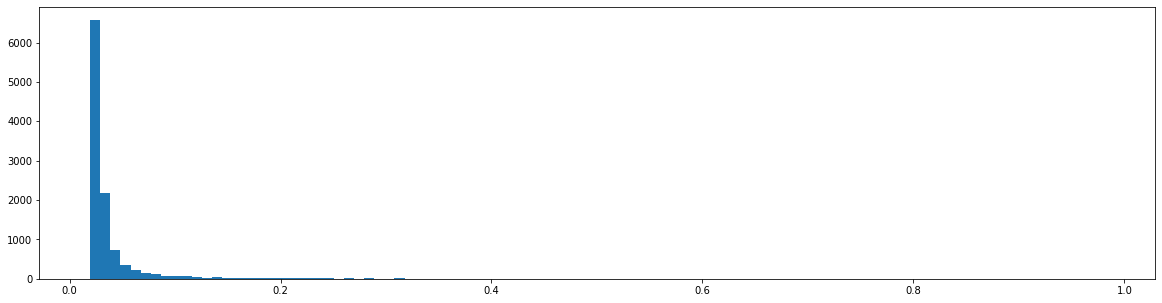

In [20]:
#@title
ds = get_dataset(TEST_FILENAMES, augment=False, repeat=False, dim=config['HEIGHT'],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") for img, img_name in iter(ds.unbatch())])

submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name')

print(f"Test predictions {len(submission[submission['target'] > .5])}|{len(submission[submission['target'] <= .5])}")

print('Top 10 samples')
display(submission.head(10))

print('Top 10 positive samples')
display(submission.query('target > .5').head(10))

fig = plt.subplots(figsize=(20, 5))
plt.hist(submission['target'], bins=100)
plt.show()

# Test set predictions

In [21]:
#@title
submission.to_csv(SUBMISSION_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
9905,ISIC_0052060,0.025071
1443,ISIC_0052349,0.024025
3120,ISIC_0058510,0.024938
4870,ISIC_0073313,0.025041
5494,ISIC_0073502,0.027436
4537,ISIC_0074618,0.031285
4819,ISIC_0076801,0.031562
7203,ISIC_0077586,0.030803
10897,ISIC_0082004,0.032975
5093,ISIC_0082785,0.026556


,target
count,10982.000000
mean,0.042474
std,0.059648
min,0.019437
25%,0.024870
50%,0.027297
75%,0.034787
max,0.981235
